# Testing out the ID algoritihm of Bhaskara et al.
Stephen Becker, March 6 2023

"Residual Based Sampling for Online Low Rank Approximation", by Aditya Bhaskara, Silvio Lattanzi, Sergei Vassilvitskii and Morteza Zadimoghaddam. FOCS, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
from numpy.random import default_rng
import scipy.linalg as sli
import scipy.io as sio

%reload_ext autoreload
%autoreload 2
import rID
rng=default_rng()

We'll make a Python "class" for stored columns for the ID.  You can add columns to the class (and their index), and the class will maintain a QR decomposition of the columns

This particular class has three "lengths" associated with it:
1. `k_max` is the maximum number of columns
2. `k_current` is the current number of columns that have been added to it
3. `k_previous` <= `k_current` is the number of columns in the "previous" set (using Bhaskara et al.'s notation). By default, projection is done with respect to the "previous" set
    - Calling the method `.mergePreviousWithCurrent()` will include *all* the columns into the "previous" set

In [386]:
class stored_columns:
    def __init__(self, k = np.Inf):
        self.indices = []   # indices of the columns; of size k_current
        self.k_max   = k    # upper limit on # of columns
        self.k_current  = 0
        self.k_previous = 0 # <= k_current
        self.columns = []   # the columns
        self.Q = []         # orthonormal version of the columns, Q.T@Q = I
        self.R = []         # columns = Q@R, i.e., R = Q.T@columns
    def mergePreviousWithCurrent(self):
        self.k_previous = self.k_current

    def addColumn(self, newCol, newInd):
        """ adds a column (and its index) to the set"""
        if self.k_current >= self.k_max:
            # do nothing. Should we give a warning??
            return False
        elif self.k_current == 0:
            # No need to orthogonalize it since nothing yet in the set. Just normalize it
            self.columns = np.reshape(newCol, (-1,1) ) # ensure it is column vector of size (n,1), not size (n,)
            self.Q = np.reshape( newCol / sli.norm(newCol), (-1,1) )
            self.R = np.reshape( sli.norm(newCol), (1,1))
        else:
            # Update QR: orthogonalize x <- x - QQ'x, and then normalize
            q            = newCol - self.project(newCol, full=True)
            self.Q       = np.column_stack( (self.Q, q/sli.norm(q)) )
            # And update R
            self.R = np.row_stack( (self.R, np.zeros((1,self.k_current))))
            self.R = np.column_stack( (self.R, self.Q.T@newCol ))
            
            self.columns = np.column_stack( (self.columns, newCol ) )

        self.indices.append( newInd )
        self.k_current += 1
        return True
    
    # Todo: allow adding multiple columns at once: do X - project, then do QR 
    # Todo: allow a re-orthogonalization routine to account for loss in precision
    
    def project(self, X, justQtX = False, full=False):
        """ Projects X into the range of chosen columns 
        Implicitly restricts to just "k_previous"
        This does Q*Q'*X, but if justQtX is True, then does Q'*X (saves some time if you just need the Euclidean norm)
        """
        if full == False:
            k = self.k_previous
        else:
            k = self.k_current
        if k==0:
            if justQtX:
                if X.ndim > 1:
                    return np.zeros( shape=(1,X.shape[1]) ) # not sure what a good shape is here...
                else:
                    return np.zeros( shape=(1,) )
            else:
                return 0*X
        QtX = self.Q[:,:k].T @ X
        if justQtX:
            return QtX  # for efficient norm computations
        # if QtX.ndim == 0:
        #     return QtX*self.Q[:,:k] # issues with scalar
        # else:
        return self.Q[:,:k]@( QtX )


#### Load dataset, make error metric

In [409]:
A    = rID.load_JHTDB_data(which_component="x",nsample=64,data_name="mhd")
nrmX = sli.norm(A) # Frobenius norm
# relError = lambda S : np.sqrt( 1 - ( sli.norm( S.project(A,justQtX=True) )/nrmX )**2 )
relError = lambda S : np.sqrt(np.abs( 1 - ( sli.norm( S.project(A,justQtX=True) )/nrmX )**2 )) # ought to be positive but not always due to rounding

# Another equivalent (slower) way to compute error:
# C, residues, rnk, singA = sli.lstsq( S.columns, A)
# print( np.sqrt(np.sum(residues))/nrmX ) # same as sli.norm( S.columns@C - A )/nrmX

#### Algorithm #3 from the Bhaskara et al. paper

In [401]:
def rID_BhaskaraAlgo3(A, k=10, xi=0.05, rng=default_rng(), coefficientUpdateFcn = None):
    """
    Description: Randomized ID using residual based CSS, solve least square problem to get coefficient of the new columns
    Follows Algorithm 3 of Bhaskara et al. "Residual Based Sampling for Online Low Rank Approximation" (FOCS, 2019)

    A is a m x n matrix, where we "stream" over the columns
    k is the number of columns to save
    xi is an target value of the Frobenius norm error (*absolute* error, not relative)

    Optional: SA is a l x n matrix, a sketched version of A, which we do assume we can store in memory
      (For now, we don't use that... later, when we start making *coefficients*, we will use that)

    March 2023
    """
    m, n = np.shape(A)
    sigma = 0.
    S     = stored_columns(k)

    # Let's make coefficients
    C     = np.zeros( (k,n) )

    for column_index in range(n):
        u = A[:,column_index]

        # u_perp  = u - S.project(u)
        # nrm_u_perp2 = sli.norm(u_perp)**2
        # Faster way:
        Su      = S.project(u,justQtX=True,full=True)
        kk      = S.k_previous
        nrm_u_perp2 = sli.norm(u)**2 - sli.norm( Su[:kk] )**2
        pu = (k/160./xi) * nrm_u_perp2
            
        prob_sample = np.minimum(pu, 1)
        roll = rng.random()
        if roll <= prob_sample: 
            success = S.addColumn( u, column_index )
            if success and (coefficientUpdateFcn is not None):
                kk = S.k_current
                C[:kk,:] = coefficientUpdateFcn( C[:kk,:], S, u)
            # Update the projection:
            Su      = S.project(u,justQtX=True,full=True) # can save some work by only updating last component if needed
        # Update the coefficients for just this one sample
        kk = S.k_current
        # C[:kk,column_index] = sli.solve_triangular( S.R, S.Q.T@u)
        C[:kk,column_index] = sli.solve_triangular( S.R, Su) # re-use the projection to save time

        if pu < 1:
            sigma += pu
        if pu >= 1 or sigma >= 1:
            sigma = 0
            S.mergePreviousWithCurrent()
    S.mergePreviousWithCurrent()
    # There's a chance we didn't alot our full budget of k rows; in that case, make C smaller
    kk = S.k_current
    return S, C[:kk,:]

In [334]:
def coeffUpdate_basicSketch( C, S, u, Omega, SA):
    """ Naive coefficient updates"""
    # We could keep an internal counter that stores the sketched columns
    # For now, do it fresh every time, slightly slower
    # Solve || Sketch( columns * C - A ) || where A is data matrix,
    #   and Sketch(A) is prestored in SA
    #   and columns is accessed via S.columns
    # We overwrite everything already in C
    C = sli.lstsq( Omega@S.columns, SA)[0]
    return C

def coeffUpdate_sketchJustUpdate( C, S, u, Omega, SA, subtractResid = False ):
    """ Keep old coefficients fixed, only sketch new one """
    k = S.k_current
    if k==1 :
        # no old coefficients, so fall back
        return coeffUpdate_basicSketch( C, S, u, Omega, SA)
    Sq   = Omega@S.Q[:,-1]
    qSSA = Sq.T@SA
    if subtractResid:
        qSSA -= ((Sq.T@Omega)@S.columns)@C
    RC_new = qSSA/(sli.norm(Sq)**2) # aka RC_new = Sq \ SA
    RC = S.R[:-1,:-1] @ C[:-1,:]  # old coefficients, keep as-is
    RC = np.row_stack( (RC, RC_new))
    C = sli.solve_triangular( S.R, RC )
    return C

#### Run their algorithm:

In [402]:
m,n = A.shape  # 4096 x 1000
print(m,n)
k = 10
S, C = rID_BhaskaraAlgo3(A, k=k, xi=10)
# S.columns
print( S.indices )

# Find optimal error (would require a second pass through data)
print(f"Optimal (multipass) relative Frobenius norm error is\t   {100*relError(S):.2f}%" )
# S.Q

# And what if we use the one-pass coefficient matrix C? Error should be higher
err0 = sli.norm( S.columns@C - A )/nrmX
print(f"... and error using naive one-pass coefficients is         {100*err0:.2f}%")

# And try a better coefficient update
oversampling = 100 # 10 is too small
ell = k + oversampling # size of sketch
Omega = rng.standard_normal(size=(ell,m))/np.sqrt(ell)
SA    = Omega@A  # Sketch the data
# If we've normalized properly, then SA and A should have similar Frobenius norms
# sli.norm(SA), sli.norm(A) # Yes, roughly the same

S1, C1 = rID_BhaskaraAlgo3(A, k=k, xi=10, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_basicSketch(C,S,u,Omega,SA) )
err1 = sli.norm( S1.columns@C1 - A )/nrmX
print(f"... and error using sketched coefficient update, ver 1, is {100*err1:.2f}%")

S2, C2 = rID_BhaskaraAlgo3(A, k=k, xi=10, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA) )
err2 = sli.norm( S2.columns@C2 - A )/nrmX
print(f"... and error using sketched coefficient update, ver 2, is {100*err2:.2f}%")

S3, C3 = rID_BhaskaraAlgo3(A, k=k, xi=10, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA, subtractResid=True) )
err3 = sli.norm( S3.columns@C3 - A )/nrmX
print(f"... and error using sketched coefficient update, ver 3, is {100*err3:.2f}%")

4096 1000
[0, 31, 51, 57, 216, 260, 266, 284, 365, 426]
Optimal (multipass) relative Frobenius norm error is	   1.85%
... and error using naive one-pass coefficients is         2.09%
... and error using sketched coefficient update, ver 1, is 1.89%
... and error using sketched coefficient update, ver 2, is 24.18%
... and error using sketched coefficient update, ver 3, is 2.02%


#### Sanity check: choose columns at random
Is this better, worse, or about the same as the fancy algorithm?

Conclusion: about the same, or even slightly better

(re-run this several times, since the results are random)

In [249]:
randInd = rng.choice( n, k)
S_rand     = stored_columns(k)
for i in randInd:
    S_rand.addColumn( A[:,i], i )
S_rand.mergePreviousWithCurrent()

# S.columns
print( S_rand.indices )

# Find optimal error (would require a second pass through data)
print(f"Relative Frobenius norm error is {100*relError(S_rand):.2f}%" )
# S.Q

[808, 903, 29, 56, 927, 936, 950, 70, 594, 617]
Relative Frobenius norm error is 1.84%


### Systematic tests
Running many times to get statistics

In [410]:
m,n = A.shape  # 4096 x 1000
k   = 10
oversampling = 100 # 10 is too small
ell = k + oversampling # size of sketch
nReps = int(3e1)
xi = 10
print(f"A is {m}x{n}, and choose k={k} columns for ID, sketch size {ell}, and {nReps} runs")

nAlgo = 6
errors= np.zeros( (nReps,nAlgo) )
for rep in range(nReps):

    S, C = rID_BhaskaraAlgo3(A, k=k, xi=xi)
    errMultiPass = relError(S)

    # And what if we use the one-pass coefficient matrix C? Error should be higher
    err0 = sli.norm( S.columns@C - A )/nrmX

    Omega = rng.standard_normal(size=(ell,m))/np.sqrt(ell)
    SA    = Omega@A  # Sketch the data

    S1, C1 = rID_BhaskaraAlgo3(A, k=k, xi=xi, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_basicSketch(C,S,u,Omega,SA) )
    err1 = sli.norm( S1.columns@C1 - A )/nrmX

    S2, C2 = rID_BhaskaraAlgo3(A, k=k, xi=xi, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA) )
    err2 = sli.norm( S2.columns@C2 - A )/nrmX

    S3, C3 = rID_BhaskaraAlgo3(A, k=k, xi=xi, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA, subtractResid=True) )
    err3 = sli.norm( S3.columns@C3 - A )/nrmX

    # And random:
    randInd = rng.choice( n, k)
    S_rand     = stored_columns(k)
    for i in randInd:
        S_rand.addColumn( A[:,i], i )
    S_rand.mergePreviousWithCurrent()
    err4 = relError(S_rand)

    errors[rep,:] = [ errMultiPass, err0, err1, err2, err3, err4 ]


A is 4096x1000, and choose k=10 columns for ID, sketch size 110, and 30 runs


If we're interesting in profiling:

(first, do `conda install line_profiler`)

In [372]:
%load_ext line_profiler

In [406]:
# %lprun -f rID_BhaskaraAlgo3 rID_BhaskaraAlgo3(A, k=k, xi=xi, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA, subtractResid=True) )
# %lprun -f stored_columns.project rID_BhaskaraAlgo3(A, k=k, xi=xi, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA, subtractResid=True) )

In [403]:
%timeit -n 5 -r 5 rID_BhaskaraAlgo3(A, k=k, xi=xi, coefficientUpdateFcn = lambda  C, S, u : coeffUpdate_sketchJustUpdate(C,S,u,Omega,SA, subtractResid=True) )

135 ms ± 6 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


Plot the timing results (exclude partial sketch v1 since it's very poor)

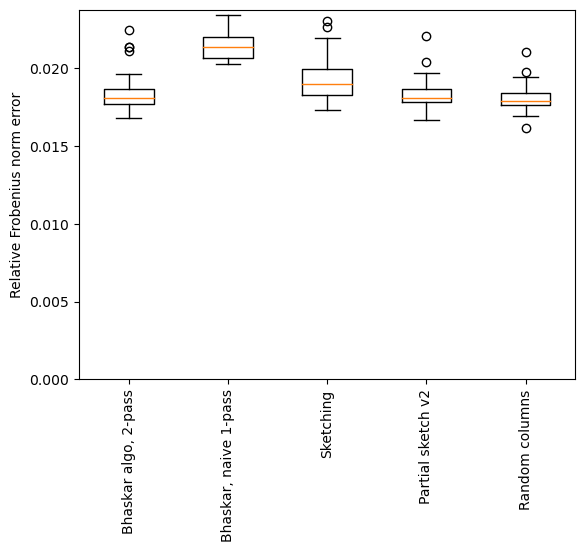

In [411]:
np.mean(errors,axis=0)

# plt.boxplot( errors )
plt.boxplot( np.hstack( (errors[:,:3], errors[:,4:]) ), 
            labels=['Bhaskar algo, 2-pass','Bhaskar, naive 1-pass','Sketching','Partial sketch v2','Random columns'])
plt.ylabel("Relative Frobenius norm error")
plt.xticks(rotation=90)
plt.ylim(bottom=0)
plt.show()